In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import matplotlib as mpl
from scipy import interpolate
import time
from scipy.stats import gaussian_kde
from statsmodels.graphics import tsaplots
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import geopandas as gpd
from matplotlib.patches import Ellipse
from scipy.special import logit, expit
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

In [3]:
from bayesfilt.telemetry.utils import *
from bayesfilt.filters.utils import get_covariance_ellipse
from bayesfilt.telemetry.utils import get_bound_from_positions, plot_relation
from simulate_tracks import *
from csg_resample_ks import *
from ssrs.turbines import TurbinesUSWTB
data_dir = os.path.join(CSG_DIR, 'raw_data')

In [4]:
fpath = os.path.join(TELEMETRY_DIR, f'csg_ge_vr.prq_tracks')
vdf = pd.read_parquet(fpath, engine='fastparquet')

In [5]:
fpath = os.path.join(TELEMETRY_DIR, f'csg_ge_vr.prq_tracks_ca')
cdf = pd.read_parquet(fpath, engine='fastparquet')

In [6]:
for igroup in ['wy','pa']:
    ntrack = vdf.loc[vdf['Group']==igroup,'TrackID'].nunique()
    #print(igroup, vdf[vdf['Group']==igroup].shape[0], ntrack-1)
    print(igroup, vdf.loc[vdf['Group']==igroup,'TimeLocal'].min(), vdf.loc[vdf['Group']==igroup,'TimeLocal'].max())

wy 2019-03-31 17:00:14 2020-05-31 20:55:32
pa 2009-02-20 10:49:38 2020-12-31 18:00:51


<AxesSubplot: >

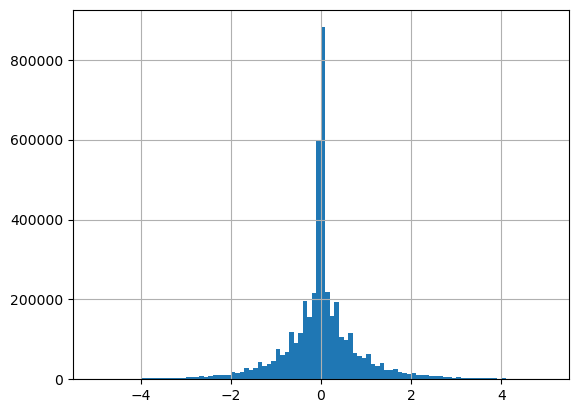

In [7]:
vdf.VelocityVer.diff().hist(bins=100, range=(-5,5))

<AxesSubplot: >

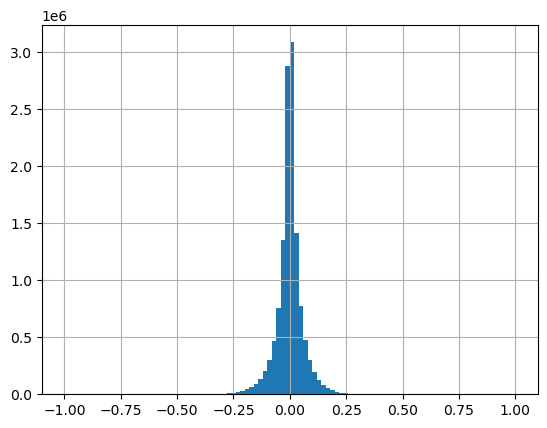

In [38]:
cdf.AccelerationVer.hist(bins=100, range=(-1,1))

In [9]:
cdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12975662 entries, 0 to 12975661
Data columns (total 34 columns):
 #   Column             Dtype         
---  ------             -----         
 0   TrackTimeElapsed   float32       
 1   PositionX          float32       
 2   PositionX_var      float32       
 3   VelocityX          float32       
 4   VelocityX_var      float32       
 5   AccelerationX      float32       
 6   AccelerationX_var  float32       
 7   TrackID            int16         
 8   PositionY          float32       
 9   PositionY_var      float32       
 10  VelocityY          float32       
 11  VelocityY_var      float32       
 12  AccelerationY      float32       
 13  AccelerationY_var  float32       
 14  Altitude           float32       
 15  Altitude_var       float32       
 16  VelocityVer        float32       
 17  VelocityVer_var    float32       
 18  AccelerationVer    float32       
 19  AccelerationZ_var  float32       
 20  TimeUTC            dat

In [10]:
for igroup in vdf.Group.unique():
    vbool = (vdf['Group']==igroup) & ((vdf['TrackID']>0))
    print(igroup, vbool.sum()/(vdf['Group']==igroup).sum())
    print(igroup, vdf[vbool].TrackID.nunique())
    print(igroup, vdf[vbool].AnimalID.nunique())
#     cbool = (cdf['Group']==igroup) & ((cdf['AltitudeAgl']<200))
    #print(igroup, cdf[cbool].shape[0]/cdf[cdf['Group']==igroup].shape[0])
#     print(igroup, vdf[vdf['Group']==igroup].shape)
#     print(igroup, cdf[cdf['Group']==igroup].TimeLocal.min())
#     print(igroup, cdf[cdf['Group']==igroup].TimeLocal.max())
# #     vbool = (cdf['Group']==igroup) & ((cdf['TrackID']>0))
#     print(igroup, vbool.sum()/(cdf['Group']==igroup).sum())

hr 0.8592598110483783
hr 282
hr 5
pa 0.23796153070145942
pa 607
pa 9
wy 0.594730604251227
wy 7411
wy 35


<AxesSubplot: >

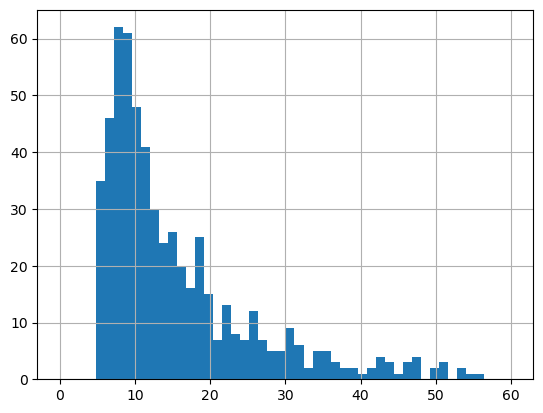

In [11]:
cdf[cdf['Group']=='pa'].groupby('TrackID')['TrackTimeElapsed'].max().divide(60).hist(bins=50, range=(0,60))

pa 15.485996705107084 0.25     8.541667
0.50    12.450000
0.75    21.575001
Name: TrackTimeElapsed, dtype: float64
wy 25.016866819592497 0.25     8.200000
0.50    14.950000
0.75    30.049999
Name: TrackTimeElapsed, dtype: float64


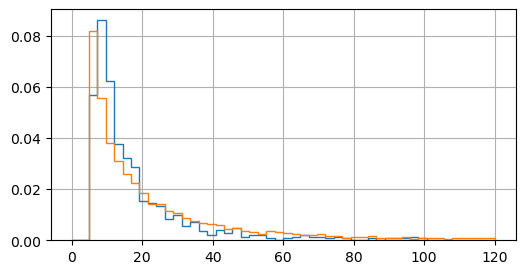

In [12]:
fig, ax = plt.subplots(figsize=(6,3))
for igroup in ['pa','wy']:
    idf = cdf[cdf['Group']==igroup].groupby('TrackID')['TrackTimeElapsed'].max().divide(60)
    print(igroup, (idf>30).sum()*100/idf.shape[0], idf.quantile([0.25,0.50,0.75]))
    idf.hist(bins=50, range=(0,120), density=True, ax=ax, label=igroup, histtype='step')

In [13]:
ibool = vdf['Group'] == 'wy'
bnds = [vdf[ibool].Longitude.min(), vdf[ibool].Latitude.min(), vdf[ibool].Longitude.max(), vdf[ibool].Latitude.max()]
tb = TurbinesUSWTB(bounds=bnds, min_hubheight=70., out_fpath='nes_turb')
tb.print_details()

TurbinesUSWTDB: Importing turbine data from USWTDB..
TurbinesUSWTDB: Successfully imported turbine data from USWTDB..
Number of projects: 35
Number of turbines: 2201
Hub height (min,median,max): 72.0, 80.0, 95.0
Rotor Dia (min,median,max): 52.0, 91.0, 136.0
    Project                   State Year  Count Hub_Hght  Rotor_Dia 
1.  Ekola Flats               WY    2020  58    82.0      136.0     
2.  TB Flats I & II           WY    2021  132   82.0      136.0     
3.  Niyol Wind                CO    2021  75    90.0      127.0     
4.  Cedar Springs III         WY    2020  48    89.0      127.0     
5.  Cedar Springs II          WY    2020  73    89.0      127.0     
6.  Mountain Breeze           CO    2020  62    89.0      127.0     
7.  Corriedale Wind Energy P  WY    2020  21    89.0      127.0     
8.  Willow Creek Wind Energy  SD    2020  38    89.0      127.0     
9.  Roundhouse                WY    2020  82    89.0      127.0     
10. Cedar Springs I           WY    2020  72    89.0

In [14]:
ibool = vdf['Group'] == 'pa'
bnds = [vdf[ibool].Longitude.min(), vdf[ibool].Latitude.min(), vdf[ibool].Longitude.max(), vdf[ibool].Latitude.max()]
tb = TurbinesUSWTB(bounds=bnds, min_hubheight=70., out_fpath='nes_turb_pa')
tb.print_details()

TurbinesUSWTDB: Importing turbine data from USWTDB..
TurbinesUSWTDB: Successfully imported turbine data from USWTDB..
Number of projects: 55
Number of turbines: 1699
Hub height (min,median,max): 70.0, 80.0, 131.0
Rotor Dia (min,median,max): 70.5, 87.0, 145.0
    Project                   State Year  Count Hub_Hght  Rotor_Dia 
1.  Black Rock                WV    2021  23    107.5     145.0     
2.  Big Level                 PA    2019  25    131.0     137.0     
3.  Beech Ridge II            WV    2020  20    89.0      127.0     
4.  Cassadaga                 NY    2021  37    91.0      117.0     
5.  Dutch Hill/Cohocton       NY    2009  50    80.0      116.0     
6.  Arkwright Summit          NY    2018  36    95.0      110.0     
7.  Ringer Hill               PA    2016  14    98.3      103.0     
8.  Marsh Hill                NY    2014  10    80.0      103.0     
9.  Orangeville Wind          NY    2013  58    80.0      100.0     
10. Laurel Hill               PA    2012  30    80.

## Log-likelihood maximization

In [15]:
def resample_x(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='X')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['PositionX'].values,
        error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()
def resample_y(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='Y')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['PositionY'].values,
        error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()

In [16]:
list_of_track_ids = np.random.choice(vdf['TrackID'].unique()[1:],int(36*2))
list_of_dftrack = [vdf[vdf['TrackID'] == ix] for ix in list_of_track_ids if ix != 0]
list_of_sigma = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.4, 2.]

In [17]:
list_of_loglik_x = []
for isigma in list_of_sigma:
    results = run_loop(
            func=partial(resample_x, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*100)}'
        )
    list_of_loglik_x.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:02<00:00, 29.22it/s]


In [18]:
list_of_loglik_y = []
for isigma in list_of_sigma:
    results = run_loop(
            func=partial(resample_y, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*100)}'
        )
    list_of_loglik_y.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:02<00:00, 29.36it/s]


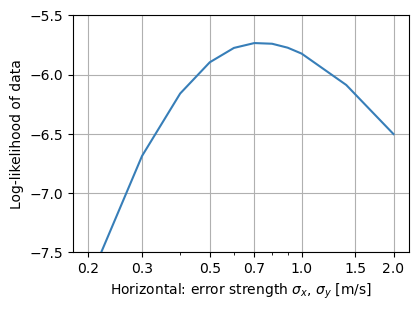

In [19]:
fig, ax = plt.subplots()
idata = [np.mean(ix) + np.mean(iy) for ix,iy in zip(list_of_loglik_x,list_of_loglik_y)]
ax.semilogx(list_of_sigma, idata, '-r', color=clrs[0])
ax.set_xticks([0.2, 0.3, 0.5, 0.7, 1., 1.5, 2.])
# f1 = mpl.ticker.ScalarFormatter()
# f1.set_scientific(False)
# ax.xaxis.set_major_formatter(f1)
f2 = mpl.ticker.StrMethodFormatter('{x:.1f}')
ax.xaxis.set_major_formatter(f2)
ax.grid(True)
ax.set_xlabel(r'Horizontal: error strength $\sigma_x$, $\sigma_y$ [m/s]')
ax.set_ylabel('Log-likelihood of data')
ax.set_ylim([-7.5,-5.5])
ax.set_yticks([-7.5, -7, -6.5, -6, -5.5])
save_paper_figure(fig, name=f'rs_loglik_hor')

In [20]:
def resample_z(dftrack, sigma):
    track_id = dftrack['TrackID'].iloc[0]
    sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
    rs_x = sampler(error_strength=sigma, flag='Z')  # 0.75
    rs_x.resample(
        times=dftrack['TrackTimeElapsed'].values,
        locs=dftrack['Altitude'].values,
        error_std=dftrack['ErrorVDOP'].values * 4.5,
        start_state_std=[4., 2., 2.],
        object_id=track_id
    )
    return rs_x.kf.dfs.MetricLogLik.mean()
list_of_sigma_z = [0.006, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.07, 0.1, 0.2]
list_of_loglik_z = []
for isigma in list_of_sigma_z:
    results = run_loop(
            func=partial(resample_z, sigma=isigma),
            input_list=list_of_dftrack,
            desc=f'CAresampler, {int(isigma*1000)}'
        )
    list_of_loglik_z.append(results)

CAresampler, 200: 100%|██████████| 72/72 [00:02<00:00, 29.54it/s]


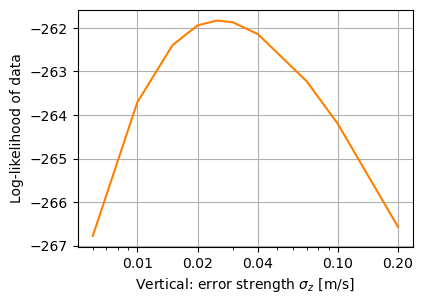

In [21]:
fig, ax = plt.subplots()
idata_z = [np.sum(ix) for ix in list_of_loglik_z]
ax.semilogx(list_of_sigma_z, idata_z, '-b', color=clrs[1])
ax.set_xticks([0.01, 0.02, 0.04, 0.1, 0.2])
# f1 = mpl.ticker.ScalarFormatter()
# f1.set_scientific(False)
# ax.xaxis.set_major_formatter(f1)
f2 = mpl.ticker.StrMethodFormatter('{x:.2f}')
ax.xaxis.set_major_formatter(f2)
ax.grid(True)
ax.set_xlabel(r'Vertical: error strength $\sigma_z$ [m/s]')
ax.set_ylabel('Log-likelihood of data')
save_paper_figure(fig, name=f'rs_loglik_ver')

## HDOP and VDOP distributions

In [22]:
xgrid = np.linspace(0,6,100)
kde_fac=0.12
ibool = (vdf['Group'].isin(['wy'])) & (vdf['TrackID']>0)
kernel_hor = gaussian_kde(vdf.loc[ibool,'ErrorHDOP'].values, bw_method=kde_fac)
y_hor_wy = kernel_hor(xgrid)
kernel_ver = gaussian_kde(vdf.loc[ibool,'ErrorVDOP'].values, bw_method=kde_fac)
y_ver_wy = kernel_ver(xgrid)
ibool = (vdf['Group'].isin(['pa'])) & (vdf['TrackID']>0)
kernel_hor = gaussian_kde(vdf.loc[ibool,'ErrorHDOP'].values, bw_method=kde_fac)
y_hor_pa = kernel_hor(xgrid)
kernel_ver = gaussian_kde(vdf.loc[ibool,'ErrorVDOP'].values, bw_method=kde_fac)
y_ver_pa = kernel_ver(xgrid)

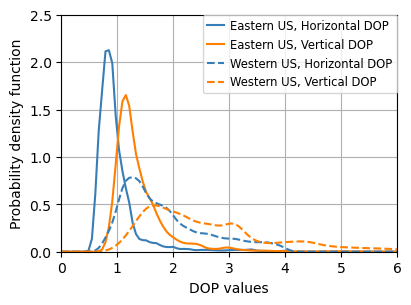

In [23]:
fig, ax = plt.subplots()
ax.plot(xgrid, y_hor_pa, '-b', color=clrs[0], label='Eastern US, Horizontal DOP')
ax.plot(xgrid, y_ver_pa, '-r', color=clrs[1],label='Eastern US, Vertical DOP')
ax.plot(xgrid, y_hor_wy, '--b', color=clrs[0],label='Western US, Horizontal DOP')
ax.plot(xgrid, y_ver_wy, '--r', color=clrs[1],label='Western US, Vertical DOP')
ax.set_xlabel('DOP values')
ax.set_ylabel('Probability density function')
ax.set_xlim([0,6])
ax.set_ylim([0,2.5])
ax.grid(True)
ax.legend(borderaxespad=0., handlelength=1.5, handletextpad=0.5, fancybox=True, fontsize='small',)
save_paper_figure(fig, name=f'data_track_dop')
#fig.savefig(os.path.join(FIG_DIR,f'track_dop.png'), dpi=200, bbox_inches='tight')

## Plotting data within the US

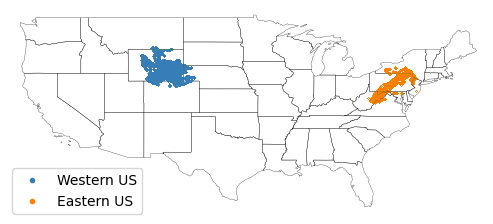

In [24]:
usa = gpd.read_file(os.path.join(data_dir, 'maps', 'usa_states', 'cb_2018_us_state_20m.shp'))
fig, ax = plt.subplots()
#usa.plot(ax=ax, column='GEOID', legend=False, cmap='OrRd', facecolor="none", edgecolor="black")
usa.boundary.plot(ax=ax, linewidth=0.2, color='k')
idf = cdf[(cdf['Group']=='wy') & (cdf['TrackID']>0)]
ax.plot(idf['Longitude'], idf['Latitude'], '.r', color = clrs[0], alpha=0.2, markersize=0.1, label='Western US')
idf = cdf[(cdf['Group']=='pa') & (cdf['TrackID']>0)]
ax.plot(idf['Longitude'], idf['Latitude'], '.b', color = clrs[1], alpha=0.2, markersize=0.1, label='Eastern US')
ax.set_xlim([-126, -66])
ax.set_ylim([25, 50])
#lg = ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0., markerscale=60)
lg = ax.legend(bbox_to_anchor=(0.005, 0.2), loc=2, borderaxespad=0., markerscale=60)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
_ = ax.axis(False)
ax.set_aspect('equal')
save_paper_figure(fig, name='data_usa_geo.png',w=6,h=7)

In [25]:
ccrs.CRS('ESRI:102008').to_proj4()
myproj = mpl.projections.register_projection(ccrs.CRS)

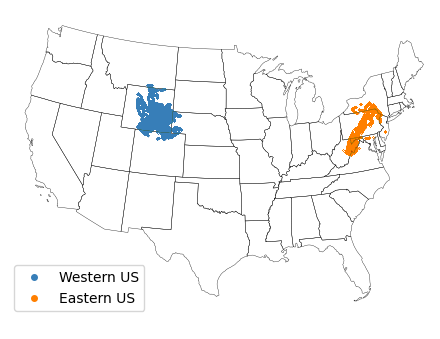

In [26]:
usa = usa.to_crs("ESRI:102008")
fig, ax = plt.subplots()
#fig, ax = plt.subplots(subplot_kw={'projection': myproj('ESRI:102008')})
#usa.plot(ax=ax, column='GEOID', legend=False, cmap='OrRd', facecolor="none", edgecolor="black")
usa.boundary.plot(ax=ax, linewidth=0.25, color='k')
#usa.plot(ax=ax, transform=ccrs.PlateCarree())
idf = cdf[(cdf['Group']=='wy') & (cdf['TrackID']>0)]
ax.plot(idf['PositionX'], idf['PositionY'], '.r', color = clrs[0], alpha=0.2, markersize=0.1, label='Western US')
idf = cdf[(cdf['Group']=='pa') & (cdf['TrackID']>0)]
ax.plot(idf['PositionX'], idf['PositionY'], '.b', color = clrs[1], alpha=0.2, markersize=0.1, label='Eastern US')
# idf = cdf[(cdf['Group']=='wy') & (cdf['TrackID']>0)]
# ax.plot(idf['Longitude'], idf['Latitude'], '.r', color = clrs[0], alpha=0.2, markersize=0.1, label='Western US')
# idf = cdf[(cdf['Group']=='pa') & (cdf['TrackID']>0)]
# ax.plot(idf['Longitude'], idf['Latitude'], '.b', color = clrs[1], alpha=0.2, markersize=0.1, label='Eastern US')
ax.set_xlim([-2.4e6, 2.2e6])
ax.set_ylim([-2e6, 1.5e6])
#lg = ax.legend(bbox_to_anchor=(1.005, 1), loc=2, borderaxespad=0., markerscale=60)
lg = ax.legend(bbox_to_anchor=(0.01, 0.2), loc=2, borderaxespad=0., markerscale=80)
for lh in lg.legendHandles: 
    lh.set_alpha(1)
_ = ax.axis(False)
#ax.set_extent([-126, -66, 25, 50], crs=ccrs.PlateCarree())
# set latitude lines to be transformed into the axis's projection
#ax.gridlines(ylocs=[30, 35, 40, 45, 50], xlocs=[-120, -100, -80], draw_labels=True);
ax.set_aspect('equal')
# ax.set_xlabel('Easting [m]')
# ax.set_ylabel('Northing [m]')
fig.set_size_inches(4.5, 3.2)
fig.subplots_adjust(left=0.01, bottom=0.0, right=0.98, top=0.999)
fig.savefig(os.path.join(FIG_DIR, 'usa_proj.png'), dpi=200)

In [27]:
list_of_series = []
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    idata = idf.TimeLocal.dt.month.value_counts().divide(idf.shape[0]/100).sort_index()
    list_of_series.append(idata)
idf = pd.concat(list_of_series, axis=1)
idf.columns = ['Western US', 'Eastern US']

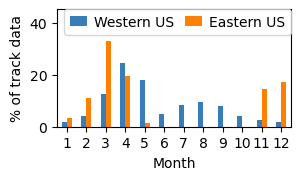

In [28]:
fig, ax = plt.subplots(figsize=(5,2.5))
idf.plot.bar(ax=ax, color=clrs[:2], rot=0)
_ = ax.set_ylabel('% of track data')
_ = ax.set_xlabel('Month')
lg = ax.legend(borderaxespad=0., loc=1, ncols=2, columnspacing=0.8, handlelength=1.25, 
               handletextpad=0.5, fancybox=True)
ax.set_ylim([0,45])
#fig.set_size_inches(2.75, 1.6)
fig.set_size_inches(3, 1.75)
fig.subplots_adjust(left=0.17, bottom=0.28, right=0.95, top=0.95)
fig.savefig(os.path.join(FIG_DIR, 'data_barplot_month.png'), dpi=200)

In [29]:
list_of_series = []
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    idata = idf.TimeLocal.dt.hour.value_counts().divide(idf.shape[0]/100).sort_index()
    list_of_series.append(idata)
idf = pd.concat(list_of_series, axis=1)
idf.columns = ['Western US', 'Eastern US']

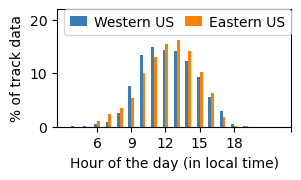

In [30]:
fig, ax = plt.subplots(figsize=(5,2.5))
idf.plot.bar(ax=ax, color=clrs[:2], rot=0)
_ = ax.set_ylabel('% of track data')
_ = ax.set_xlabel('Hour of the day (in local time)')
lg = ax.legend(borderaxespad=0., loc=1, ncols=2, columnspacing=0.8, handlelength=1.25, 
               handletextpad=0.5, fancybox=True)
ax.set_ylim([0,22])
ax.set_xticks([3,6,9,12,15,20])
fig.set_size_inches(2.75, 1.6)
fig.set_size_inches(3, 1.75)
fig.subplots_adjust(left=0.17, bottom=0.28, right=0.95, top=0.95)
fig.savefig(os.path.join(FIG_DIR, 'data_barplot_timeofday.png'), dpi=200)

In [31]:
np.arange(0,24,3)

array([ 0,  3,  6,  9, 12, 15, 18, 21])

In [32]:
for igroup in ['wy','pa']:
    idf = cdf[cdf['Group']==igroup]
    print(igroup, idf.AnimalID.nunique())
    print(igroup, idf.TrackID.nunique())

wy 35
wy 7411
pa 9
pa 607


In [33]:
for igroup in ['wy','pa']:
    idf = vdf[vdf['Group']==igroup]
    jdf = idf[idf.TrackID>0].copy()
    print(jdf.shape[0]/idf.shape[0])
    print(igroup, idf.TimeDiff.value_counts().sort_values(ascending=False).iloc[:10].divide(idf.shape[0]/100))

0.594730604251227
wy 6.0      63.050148
3.0      12.352093
5.0       1.591194
7.0       1.146558
613.0     1.025873
612.0     0.957602
614.0     0.794740
8.0       0.682125
611.0     0.669500
606.0     0.669050
Name: TimeDiff, dtype: float64
0.23796153070145942
pa 6.0     13.267705
10.0     6.978781
9.0      6.598460
4.0      6.466306
8.0      3.743359
1.0      2.830890
5.0      2.276212
32.0     1.880759
33.0     1.667059
3.0      1.529356
Name: TimeDiff, dtype: float64


## plot individual tracks for checking resampling

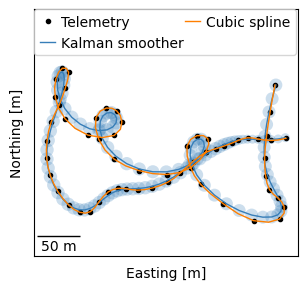

In [34]:
track_id =13
# 13, 10, 90
tstart =10
tduration  =120
fig, ax = plt.subplots(figsize=(5,5))

vtrackdf = vdf[vdf['TrackID']==track_id]
vtrackdf['TrackTimeElapsed'] -= vtrackdf['TrackTimeElapsed'].iloc[0]
vtrackdf = vtrackdf[vtrackdf['TrackTimeElapsed'].between(tstart, tstart+tduration)]

ctrackdf = cdf[cdf['TrackID']==track_id]
ctrackdf['TrackTimeElapsed'] -= ctrackdf['TrackTimeElapsed'].iloc[0]
ctrackdf = ctrackdf[ctrackdf['TrackTimeElapsed'].between(tstart, tstart+tduration)]

ax.plot(vtrackdf['PositionX'],vtrackdf['PositionY'], 'ok', markersize=3., label='Telemetry')
ax.plot(ctrackdf['PositionX'],ctrackdf['PositionY'], '-r', color=clrs[0],linewidth=1., label='Kalman smoother')

covs = [np.diag([ix,ix]) for ix in ctrackdf['PositionX_var'].values]
for xloc, yloc, icov in zip(ctrackdf['PositionX'], ctrackdf['PositionY'], covs):
    width, height, angle = get_covariance_ellipse(icov, 3.)
    ellip = Ellipse(xy=[xloc, yloc], width=width, height=height, angle=angle, fc=clrs[0], alpha=0.25, ec=None)
    ax.add_artist(ellip)
    
etime = vtrackdf['TrackTimeElapsed'].values
fx = interpolate.interp1d(etime, vtrackdf['PositionX'].values, kind='cubic')
fy = interpolate.interp1d(etime, vtrackdf['PositionY'].values, kind='cubic')
itime = np.arange(vtrackdf['TrackTimeElapsed'].iloc[0],vtrackdf['TrackTimeElapsed'].iloc[-1]+1)
xlocs = fx(itime)
ylocs = fy(itime)
ax.plot(xlocs, ylocs, '-r', color=clrs[1], linewidth=1., label='Cubic spline')
#ax.axis('off')
ax.set_yticks([])
ax.set_xticks([])
ax.set_ylabel('Northing [m]')
ax.set_xlabel('Easting [m]')
ax.set_aspect('equal')
ylim = ax.get_ylim()
ax.set_ylim([ylim[0]-30, ylim[1]+60])
my_arrow = AnchoredSizeBar(ax.transData, 50., '50 m', 3, pad=0.1, size_vertical=0.1, frameon=False)
ax.add_artist(my_arrow)
ax.legend(borderaxespad=0., ncol=2, loc=2, columnspacing=0.1, handlelength=1.1,
          handletextpad=0.4, fancybox=True,)
fig.set_size_inches(3.2, 2.8)
fig.subplots_adjust(left=0.01, bottom=0.1, right=0.999, top=0.98)
fig.savefig(os.path.join(FIG_DIR, f'rs_path_{track_id}'), dpi=200)
# save_paper_figure(fig, name=f'rs_path_{track_id}')
# fig.tight_layout()
# fig.savefig(os.path.join(FIG_DIR,f'fig_resampled_space_{track_id}.png'), dpi=200, bbox_inches='tight')

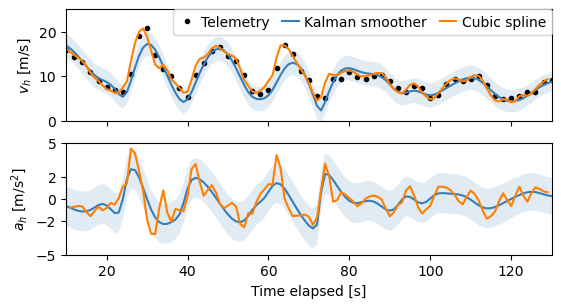

In [35]:
fig, ax = plt.subplots(2,1,figsize=(6,3), sharex=True)
ax[0].plot(vtrackdf['TrackTimeElapsed'],vtrackdf['VelocityHor_TU'],'.k', label='Telemetry')
ax[0].plot(
    ctrackdf['TrackTimeElapsed'],
    ctrackdf['VelocityHor'], '-r', 
    color=clrs[0], 
    linewidth=1.5, 
    label='Kalman smoother'
)
vel_std = np.sqrt((ctrackdf['VelocityX_var'] + ctrackdf['VelocityY_var'])/2)
cb = ax[0].fill_between(
    ctrackdf['TrackTimeElapsed'], 
    ctrackdf['VelocityHor'] - 3.*vel_std, 
    ctrackdf['VelocityHor'] + 3.*vel_std,
    color = clrs[0], 
    alpha=0.15, 
    ec=None
)
hvel = np.sqrt(np.diff(xlocs)**2 + np.diff(ylocs)**2)
#ktime = itime[1:] - itime[1]
ax[0].plot(itime[:-1], hvel, '-r', color=clrs[1], label='Cubic spline')
ax[0].set_ylabel(r'$v_h$ [m/s]')
# heading = vtdf['HeadingHor_TU']
# heading[heading > 180] -= 360
#ax[1].plot(vtdf['TrackTimeElapsed'],heading,'.k')
ax[1].plot(
    ctrackdf['TrackTimeElapsed'],
    ctrackdf['AccnHorTangential'],'-r', 
    color=clrs[0], 
    linewidth=1.5, 
    label='Kalman smoother'
)
vel_std = np.sqrt((ctrackdf['AccelerationX_var'] + ctrackdf['AccelerationY_var'])/2)
cb = ax[1].fill_between(
    ctrackdf['TrackTimeElapsed'], 
    ctrackdf['AccnHorTangential'] - 3.*vel_std, 
    ctrackdf['AccnHorTangential'] + 3.*vel_std,
    color = clrs[0], 
    alpha=0.15, 
    ec=None
)
ax[1].set_ylabel(r'$a_h$ [m/s$^2$]')
ktime = itime[1:-1] - itime[1]
ax[1].plot(itime[1:-1], np.diff(hvel), '-r', color=clrs[1])
# vel_std = np.sqrt((ktdf['VelocityX_var'] + ktdf['VelocityY_var'])/2)
# cb = ax[0].fill_between(
#     ktdf['TrackTimeElapsed'], 
#     ktdf['VelocityHor'] - 2.*vel_std, 
#     ktdf['VelocityHor'] + 2.*vel_std,
#     color = clrs[5], alpha=0.2, ec=None
# )
# hvel = np.degrees(np.arctan2(np.diff(xlocs), np.diff(ylocs,)))
# ax[1].plot(itime[:-1], hvel, '-r', color=clrs[6])
ax[0].set_xlim([itime[0], itime[-1]])
ax[1].set_xlim([itime[0], itime[-1]])
ax[1].set_xlabel('Time elapsed [s]')
ax[0].set_ylim([0,25])
ax[1].set_ylim([-5,5])
ax[1].set_yticks([-5,-2,0,2,5])
ax[0].legend(borderaxespad=0., ncol=3, loc=1, columnspacing=0.9, handlelength=1.2,
          handletextpad=0.4)
fig.set_size_inches(6/1.1, 3.25/1.1)
fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.98)
fig.savefig(os.path.join(FIG_DIR, f'rs_tseries_{track_id}'), dpi=200)
#save_paper_figure(fig, name=f'rs_tseries_{track_id}', w=7)
# fig.tight_layout()
# fig.savefig(os.path.join(FIG_DIR,f'fig_timehistory_{track_id}.png'), dpi=200, bbox_inches='tight')

## Filter vs Smoother

In [36]:
dftrack = vdf[vdf['TrackID']==track_id]
#dftrack['TrackTimeElapsed'] = dftrack['TrackTimeElapsed'] - dftrack['TrackTimeElapsed'].iloc[0]
track_id = dftrack['TrackID'].iloc[0]
sampler = partial(ConstantAccelerationResampler, dt=1., smoother=True)
rs_x = sampler(error_strength=0.7, flag='X')  # 0.75
rs_x.resample(
    times=dftrack['TrackTimeElapsed'].values,
    locs=dftrack['PositionX'].values,
    error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
    start_state_std=[4., 2., 2.],
    object_id=track_id
)
rs_y = sampler(error_strength=0.7, flag='Y')  # 0.75
rs_y.resample(
    times=dftrack['TrackTimeElapsed'].values,
    locs=dftrack['PositionY'].values,
    error_std=dftrack['ErrorHDOP'].values * 2.5 / np.sqrt(2),
    start_state_std=[4., 2., 2.],
    object_id=track_id
)

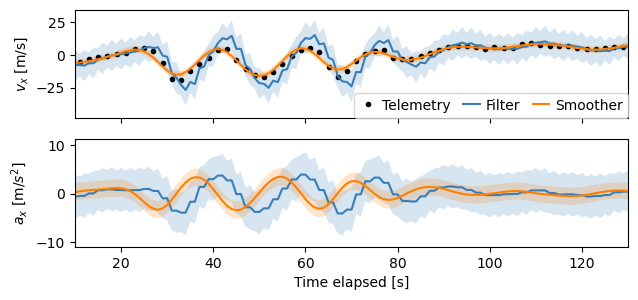

In [37]:
fig, ax = plt.subplots(2,1,figsize=(6,3), sharex=True)
cname = 'VelocityX'
#dftrack['TrackTimeElapsed'] -= dftrack['TrackTimeElapsed'].iloc[0]
ax[0].plot(dftrack['TrackTimeElapsed'],dftrack[f'{cname}_TU'],'.k', label = 'Telemetry')
#rs_x.kf.df['TimeElapsed'] -= rs_x.kf.df['TimeElapsed'].iloc[0]
rs_x.kf.plot_state_mean(cname, ax=ax[0], color=clrs[0], label='Filter')
rs_x.kf.plot_state_cbound(cname, ax=ax[0], alpha=0.2,  color=clrs[0], ec=None)
rs_x.kf.plot_state_mean(cname, ax=ax[0], color=clrs[1], smoother=True, label='Smoother')
rs_x.kf.plot_state_cbound(cname, ax=ax[0], alpha=0.2,  color=clrs[1], smoother=True, ec=None)

cname = 'AccelerationX'
#ax[1].plot(dftrack['TrackTimeElapsed'], dftrack[cname],'.k')
rs_x.kf.plot_state_mean(cname, ax=ax[1], color=clrs[0])
rs_x.kf.plot_state_cbound(cname, ax=ax[1], alpha=0.2,  color=clrs[0], ec=None)
rs_x.kf.plot_state_mean(cname, ax=ax[1], color=clrs[1], smoother=True)
rs_x.kf.plot_state_cbound(cname, ax=ax[1], alpha=0.2,  color=clrs[1], smoother=True, ec=None)

# itime = [80,100]
ax[0].set_xlim([itime[0], itime[-1]])
ax[1].set_xlim([itime[0], itime[-1]])
ax[0].set_xlabel('')
ax[1].set_xlabel('Time elapsed [s]')
ax[0].set_ylabel(r'$v_x$ [m/s]')
ax[1].set_ylabel(r'$a_x$ [m/$s^2$]')
fig.tight_layout()
ax[0].legend(borderaxespad=0., ncol=3, loc=4, columnspacing=0.9, handletextpad=0.4, handlelength=1.2)
save_paper_figure(fig, name=f'rs_smoother_{track_id}', w=7)
#fig.savefig(os.path.join(FIG_DIR,f'fig_fVSs_{track_id}.png'), dpi=200, bbox_inches='tight')